## SkillCraft
#### Classifying Starcraft 2 league-level performance
##### by Adam Wawroń

Dane, które wybrałem to zbiór danych z meczów Starcrafta 2 rozegranych w różnych ligach. Zawierają między innymi wiek gracza, podane godziny gry tygodniowo itp, ale także dane konkretnego meczu, takie jak ilość wytrenowanych jednostek specjalnych, ilość akcji wykonanych przez minimapę i, najciekawsze moim zdaniem, statystyki dotyczące tak zwanych Perception Action Cycles (PACs), czyli to jak gracz zarządza swoją uwagą.

Celem tego projektu jest nauczenie kilku różnych modeli, aby na podstawie tych danych zgadywały ligę, w jakiej znajduje się gracz.

### Processing bazy danych

Jest oczywiste, że moje dane były już preprocessowane, widać to chociażby po brakach w GameID. Mimo moich starań nie udało mi się znaleźć oryginalnej bazy, lecz mimo to postanowiłem stworzyć funkcje, które zwalidują dane w bazie. Więc powstał *data_cleaner.py* widoczny poniżej.

#### Etap walidacji
W pierwszym etapie sprawdzam, czy dane są kompletne, odpowiedniego typu i odpowiedniej wielkości.

In [2]:
import pandas as pd

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('../../data/SkillCraft.csv')
df_dirty_length = len(df)

# Drop any rows with missing values
df.dropna(inplace=True)

# Drop any rows with incorrect data types or values that do not make sense
df = df[(df['LeagueIndex'] >= 1) & (df['LeagueIndex'] <= 8) &
        (df['Age'] >= 0) & (df['HoursPerWeek'] >= 0) & (df['TotalHours'] >= 0) &
        (df['APM'] >= 0) & (df['SelectByHotkeys'] >= 0) & (df['AssignToHotkeys'] >= 0) &
        (df['UniqueHotkeys'] >= 0) & (df['MinimapAttacks'] >= 0) & (df['MinimapRightClicks'] >= 0) &
        (df['NumberOfPACs'] >= 0) & (df['GapBetweenPACs'] >= 0) & (df['ActionLatency'] >= 0) &
        (df['ActionsInPAC'] >= 0) & (df['TotalMapExplored'] >= 0) & (df['WorkersMade'] >= 0) &
        (df['UniqueUnitsMade'] >= 0) & (df['ComplexUnitsMade'] >= 0) &
        (df['ComplexAbilitiesUsed'] >= 0)]

#### Etap usuwania skrajności
Ten etap powstał, aby ograniczyć ilość danych pomimo braku błędów i pustych pól. Niestety problem usuwania skrajnych danych jest taki, że usuwa on przede wszystkim najlepszych graczy, co powoduje, że w nowej bazie danych nie ma graczy o najwyższej randze Grandmaster. Ostatecznie postanowiłem pracować na pełnej, i tak niezbyt dużej, bazie.

In [3]:
cols_to_filter = df.columns[2:]

# Calculate the IQR for each column
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Set a threshold for outlier removal (e.g., 1.5*IQR)
threshold = 10

# Remove any rows with a value outside the range [Q1 - threshold*IQR, Q3 + threshold*IQR]
df = df[~((df[cols_to_filter] < (Q1 - threshold*IQR)) | (df[cols_to_filter] > (Q3 + threshold*IQR))).any(axis=1)]

# Save the cleaned data to a new CSV file
df.to_csv('../../data/SkillCraft_clean.csv', index=False)

df_clean = pd.read_csv('../../data/SkillCraft_clean.csv')

print(df_dirty_length)
print(len(df_clean))

3338
3314


C:\Users\adamz\AppData\Local\Temp\ipykernel_1956\1583135830.py:12: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df = df[~((df[cols_to_filter] < (Q1 - threshold*IQR)) | (df[cols_to_filter] > (Q3 + threshold*IQR))).any(axis=1)]


### Drzewo decyzyjne, k-sąsiedzi i Naive Bayes
Dla potrzeby tych metod podzieliłem dane na zbiór treningowy i testowy w proporcji 70/30.


In [4]:
import pandas as pd
from sklearn.neighbors import (NeighborhoodComponentsAnalysis,KNeighborsClassifier)
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

df = pd.read_csv("../../data/SkillCraft.csv")

all_inputs = df[['Age', 'HoursPerWeek', 'TotalHours', 'APM', 'SelectByHotkeys', 'UniqueHotkeys', 'MinimapAttacks', 'NumberOfPACs', 'GapBetweenPACs', 'ActionLatency', 'ActionsInPAC', 'TotalMapExplored', 'WorkersMade', 'UniqueUnitsMade', 'ComplexUnitsMade', 'ComplexAbilitiesUsed']].values
all_classes = df['LeagueIndex'].values

(train_set, test_set, train_classes, test_classes) = train_test_split(all_inputs, all_classes, train_size=0.7, random_state=4)

nca = NeighborhoodComponentsAnalysis(random_state=2)

#### Drzewo decyzyjne

Nieprzycięte:

DD: 0.3473053892215569


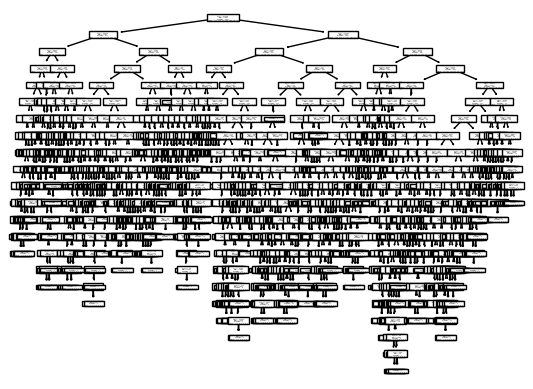

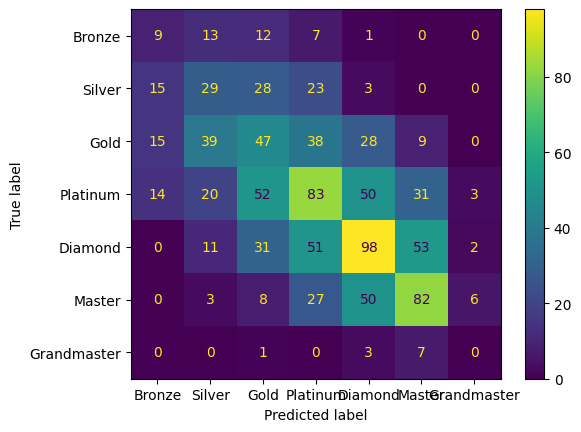

In [32]:
dtc = tree.DecisionTreeClassifier()
dtc.fit(train_set, train_classes)

predictions = dtc.predict(test_set)

print("DD:", dtc.score(test_set, test_classes))

extree = tree.export_text(dtc)
# print(extree)
plotree = tree.plot_tree(dtc)

confmtx = confusion_matrix(test_classes, predictions)
plot = ConfusionMatrixDisplay(confusion_matrix = confmtx, display_labels = ["Bronze", "Silver", "Gold", "Platinum", "Diamond", "Master", "Grandmaster"])
plot.plot()

Przycięte:

DD: 0.3902195608782435


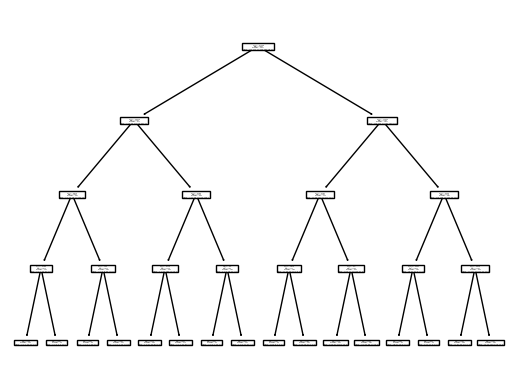

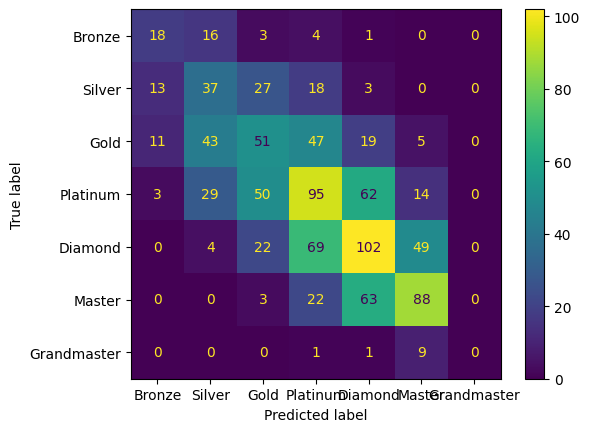

In [31]:
dtc = tree.DecisionTreeClassifier(max_depth=4) # depth of 4 was found to give the best results
dtc.fit(train_set, train_classes)
print("DD:", dtc.score(test_set, test_classes))

extree = tree.export_text(dtc)
# print(extree)
plotree = tree.plot_tree(dtc)

predictions = dtc.predict(test_set)
confmtx = confusion_matrix(test_classes, predictions)
plot = ConfusionMatrixDisplay(confusion_matrix = confmtx, display_labels = ["Bronze", "Silver", "Gold", "Platinum", "Diamond", "Master", "Grandmaster"])
plot.plot()


Nieograniczone drzewo decyzyjne osiąga skuteczność około 33%. Jest to słaby wynik biorąc pod uwagę wielkość i skomplikowanie drzewa.

Przycięte drzewo decyzyjne radzi sobie lepiej. Z dokładnością w okolicach 39% jest to całkiem szybki i skuteczny model, który poprawia część błędów nieograniczonego drzewa i "ścieśnia" macierz błędu bliżej przekątnej.

#### Metoda k-sąsiadów

kNN3:  0.2944111776447106
kNN5:  0.2944111776447106
kNN11:  0.2944111776447106


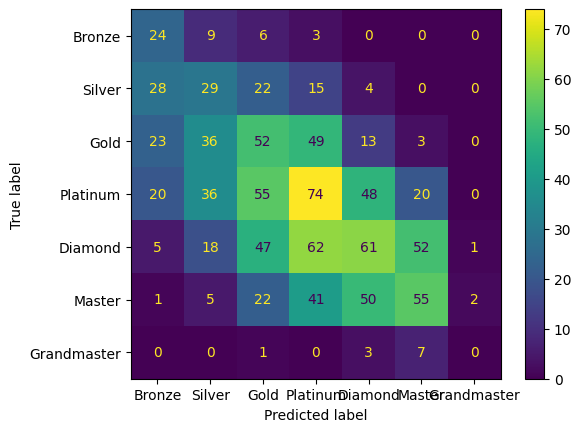

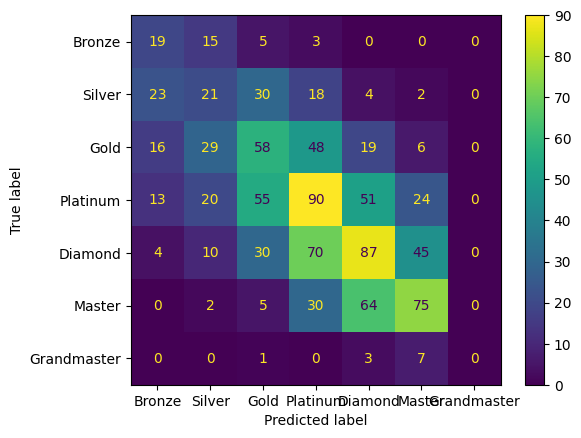

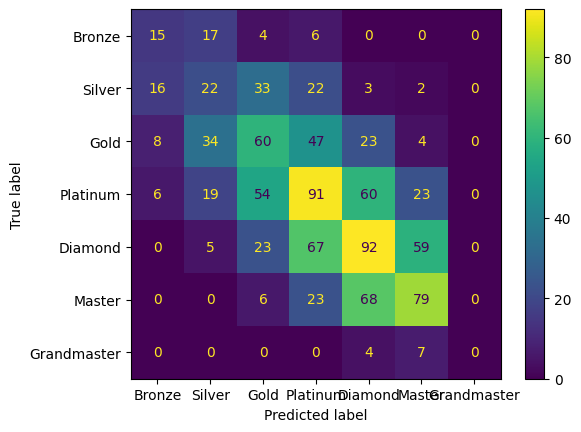

In [6]:
knn3 = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
nca_pipe3 = Pipeline([('nca', nca), ('knn3', knn3)])
nca_pipe3.fit(train_set, train_classes)  
print("kNN3: ", nca_pipe3.score(test_set, test_classes))

predictions = nca_pipe3.predict(test_set)
confmtx = confusion_matrix(test_classes, predictions)
plot = ConfusionMatrixDisplay(confusion_matrix = confmtx, display_labels = ["Bronze", "Silver", "Gold", "Platinum", "Diamond", "Master", "Grandmaster"])
plot.plot()

# # -------------------------------------------------------------------------------------------------------------------------------

knn5 = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
nca_pipe5 = Pipeline([('nca', nca), ('knn5', knn5)])
nca_pipe5.fit(train_set, train_classes) 
print("kNN5: ", nca_pipe3.score(test_set, test_classes))

predictions = nca_pipe5.predict(test_set)
confmtx = confusion_matrix(test_classes, predictions)
plot = ConfusionMatrixDisplay(confusion_matrix = confmtx, display_labels = ["Bronze", "Silver", "Gold", "Platinum", "Diamond", "Master", "Grandmaster"])
plot.plot()

# # -------------------------------------------------------------------------------------------------------------------------------

knn11 = KNeighborsClassifier(n_neighbors=11, metric='euclidean')
nca_pipe11 = Pipeline([('nca', nca), ('knn11', knn11)])
nca_pipe11.fit(train_set, train_classes) 
print("kNN11: ",nca_pipe3.score(test_set, test_classes))

predictions = nca_pipe11.predict(test_set)
confmtx = confusion_matrix(test_classes, predictions)
plot = ConfusionMatrixDisplay(confusion_matrix = confmtx, display_labels = ["Bronze", "Silver", "Gold", "Platinum", "Diamond", "Master", "Grandmaster"])
plot.plot()

Metoda k-sąsiadów została przetestowana dla 3, 5, 8, 11 i 16 sąsiadów, lecz dla wszystkich wynik wychodził taki sam, około 10 punktów procentowych gorszy niż drzewo decyzyjne i jednocześnie dłuższym czasie pracy.

#### Naive Bayes

NB:  0.374


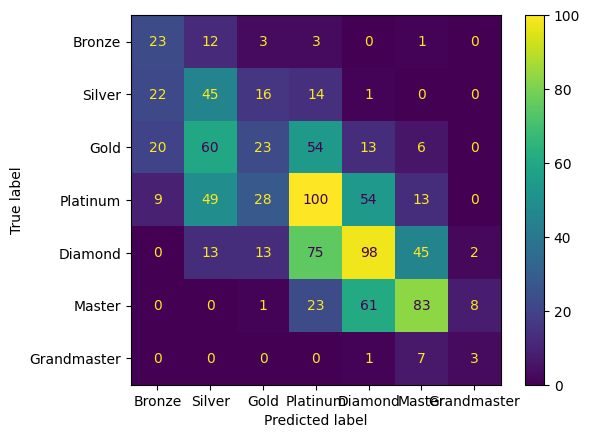

In [7]:
gnb = GaussianNB()
gnb.fit(train_set, train_classes)
print("NB: ", str(gnb.score(test_set, test_classes))[0:5])

predictions = gnb.predict(test_set)
confmtx = confusion_matrix(test_classes, predictions)
plot = ConfusionMatrixDisplay(confusion_matrix = confmtx, display_labels = ["Bronze", "Silver", "Gold", "Platinum", "Diamond", "Master", "Grandmaster"])
plot.plot()

Naive Bayes dał wyniki minimalnie gorsze od drzewa, około 37%.

#### Macierze błędów

Na macierzach widać, że pojawia się pewien wzorzec, gdyż wyraźnie widać, że linia przekątna jest najbardziej pokolorowana, a rogi prawie wcale. To by oznaczało, że modele idą w dobrym kierunku, jednak dane nie są dostatecznie jednoznaczne aby dać wynik bliski idealnemu.

Wynika to prawdopodobnie z dwóch powodów:
1. **Liczba danych** - przy 3338 wierszach tak wielu niedeterministycznych danych może być ciężko znaleźć dobre wzorce
2. **Natura lig w grze** - gracz o randze np. Platinum może być bliski awansu, wtedy statystyki są bliskie graczowi, który jest w randze wyżej bliski spadku. Dodatkowo, w StarCrafcie 2 nie można stracić rangi do końca sezonu, więc może ona nie oddawać poziomu umiejętności.

### Sieci neuronowe

#### Prosta sieć neuronowa
Pierwsza sieć neuronowa, której użyłem to prostsza wersja z biblioteki sklearn z podziałem takim samym jak wcześniej. Pozwoliło to określić między innymi topologię sieci na szybszym modelu. Po testach udało się ustalić, że kolejno warstwy 16, 8 i 4 neuronów dawały najlepsze wyniki. Mniej neuronów i efektywność spadała, więcej i model przetrenowywał się i często zgadywał tylko jedną ligę.

score on train data:  0.3921232876712329
score on test data:  0.42115768463073855


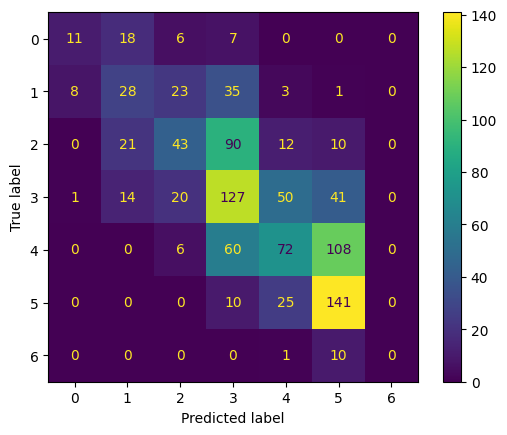

In [9]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

df = pd.read_csv("../../data/SkillCraft.csv")

all_inputs = df[['Age', 'HoursPerWeek', 'TotalHours', 'APM', 'SelectByHotkeys', 'UniqueHotkeys', 'MinimapAttacks', 'NumberOfPACs', 'GapBetweenPACs', 'ActionLatency', 'ActionsInPAC', 'TotalMapExplored', 'WorkersMade', 'UniqueUnitsMade', 'ComplexUnitsMade', 'ComplexAbilitiesUsed']].values
all_classes = df['LeagueIndex'].values

label_encoder = LabelEncoder()
all_classes = label_encoder.fit_transform(all_classes)

(train_set, test_set, train_classes, test_classes) = train_test_split(all_inputs, all_classes, train_size=0.7, random_state=4)

clf = MLPClassifier(activation='relu',
                    alpha=0.0001,
                    max_iter=1500,
                    hidden_layer_sizes=(16, 8, 4), 
                    random_state=1)

clf.fit(train_set, train_classes)     
clf.score(train_set, train_classes)

predictions_train = clf.predict(train_set)
predictions_test = clf.predict(test_set)
train_score = accuracy_score(predictions_train, train_classes)
print("score on train data: ", train_score)
test_score = accuracy_score(predictions_test, test_classes)
print("score on test data: ", test_score)
# print(predictions_train)

confmtx = confusion_matrix(test_classes, predictions_test)
plot = ConfusionMatrixDisplay(confusion_matrix = confmtx)
plot.plot()
plt.show()

Jak widać sieć neuronowa jest trochę lepsza niż drzewo decyzyjne, przekraczając 40% skuteczności. Przeskalowanie danych nie polepsza tego wyniku.

#### Model keras
Drugi model, na którym przeprowadziłem więcej testów powstał przy wykorzystaniu biblioteki keras. 

Ten model wymagał kilku innych kroków do przygotowania zbiorów i wyników.

In [12]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from ann_visualizer.visualize import ann_viz;
from sklearn import preprocessing
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

with open('../../data/SkillCraft.csv') as f:
    lines = (line.replace('"', '') for line in f if not line.startswith('#'))
    dataset = np.loadtxt(lines, delimiter=',', skiprows=1)

x = dataset[:, 2:19]
y = dataset[:, 1]

def dataSwitch(item):
    if item == 1:
        return [1, 0, 0, 0, 0, 0, 0, 0]
    elif item == 2:
        return [0, 1, 0, 0, 0, 0, 0, 0]
    elif item == 3:
        return [0, 0, 1, 0, 0, 0, 0, 0]
    elif item == 4:
        return [0, 0, 0, 1, 0, 0, 0, 0]
    elif item == 5:
        return [0, 0, 0, 0, 1, 0, 0, 0]
    elif item == 6:
        return [0, 0, 0, 0, 0, 1, 0, 0]
    elif item == 7:
        return [0, 0, 0, 0, 0, 0, 1, 0]
    elif item == 8:
        return [0, 0, 0, 0, 0, 0, 0, 1]
    else:
        raise ValueError("Item must be an integer between 1 and 8.")

better_y = np.zeros((len(y), 8))

for i in range(len(y)):
    better_y[i] = (dataSwitch(y[i]))

# Scale the data
scaler = preprocessing.StandardScaler().fit(x)
better_x = scaler.transform(x)

# for i in better_x:
#     print(i)

Na początek (poza importami bibliotek) importujemy dane w sposób zrozumiały dla modelu i dzielimy go na dane i odpowiedzi. Następnie konieczna była zmiana formatu prawidłowych odpowiedzi z typu *int* od 1 do 8 na listę o 8 elementach, w której 1 pojawiało się na odpowiednim miejscu. Następnie w samym modelu ostatnia warstwa z odpowiedzią miała 8 neuronów, każdy dający odpowiedź 0 lub 1.

Dodatkowo skalujemy dane żeby ułatwić modelowi pracę.

Poniżej pojawi się output tylko jednego z testowanych modeli, lecz wyniki podane są dla wszystkich.

Epoch 1/50
334/334 [==============================] - 1s 1ms/step - loss: 0.4969 - accuracy: 0.1101 - val_loss: 0.3800 - val_accuracy: 0.1781
Epoch 2/50
334/334 [==============================] - 0s 1ms/step - loss: 0.3524 - accuracy: 0.2382 - val_loss: 0.3378 - val_accuracy: 0.2485
Epoch 3/50
334/334 [==============================] - 0s 984us/step - loss: 0.3208 - accuracy: 0.2948 - val_loss: 0.3111 - val_accuracy: 0.3234
Epoch 4/50
334/334 [==============================] - 0s 1ms/step - loss: 0.2913 - accuracy: 0.3899 - val_loss: 0.2940 - val_accuracy: 0.3743
Epoch 5/50
334/334 [==============================] - 0s 1ms/step - loss: 0.2788 - accuracy: 0.4045 - val_loss: 0.2889 - val_accuracy: 0.3698
Epoch 6/50
334/334 [==============================] - 0s 1ms/step - loss: 0.2744 - accuracy: 0.4105 - val_loss: 0.2863 - val_accuracy: 0.3563
Epoch 7/50
334/334 [==============================] - 0s 1ms/step - loss: 0.2718 - accuracy: 0.4086 - val_loss: 0.2842 - val_accuracy: 0.3638
Epoc

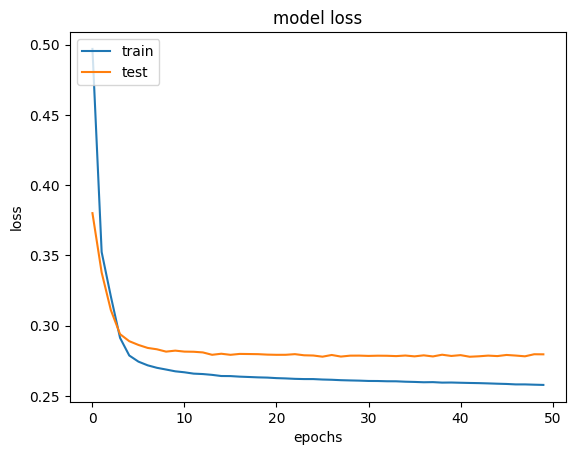

In [30]:
def makeModel(x, y, activation, optimizer):
    model = Sequential()
    model.add(Dense(16, input_dim=17, activation=activation))
    model.add(Dense(4, activation=activation))
    model.add(Dense(8, activation='softmax'))

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    history = model.fit(x, y, epochs=50, validation_split=0.2, batch_size=8)

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend(['train', 'test'], loc="upper left")
    plt.show()

    ann_viz(model, view=True, filename='network.gv', title="My graph")

makeModel(better_x, better_y, 'relu', 'adam')
# makeModel(better_x, better_y, 'relu', 'nadam')
# makeModel(better_x, better_y, 'relu', 'sgd')
# makeModel(better_x, better_y, 'sigmoid', 'nadam')
# makeModel(better_x, better_y, 'sigmoid', 'sgd')
# makeModel(better_x, better_y, 'sigmoid', 'adam')

Funkcja *makeModel()* pozwala na łatwe testowanie różnych aktywacji i optimizerów. Dzięki danym z poprzedniej sieci neuronowej szybko udało się ustalić, że warstwy 16 i 4 (i 8 jako wyjście) dają najlepsze wyniki. Potem zacząłem testy dla różnych aktywacji i optimizerów.

Po kolei:
1. Activation: relu / Optimizer: adam - najlepszy wynik 46%
2. Activation: relu / Optimizer: nadam - najlepszy wynik 46%
3. Activation: relu / Optimizer: sgd - najlepszy wynik 42%
4. Activation: sigmoid / Optimizer: adam - najlepszy wynik 44%
5. Activation: sigmoid / Optimizer: nadam - najlepszy wynik 32%
6. Activation: sigmoid / Optimizer: sgd - najlepszy wynik 44%

Ostatecznie kombinacja relu/adam okazała się najlepsza.

Wykres krzywej błędu pokazuje nam, że model się przetrenowuje, i rzeczywiście procent prawidłowych odpowiedzi przestaje rosnąć dość szybko. Jednak prawdopodobnie ponownie wynika to z danych.

## Wnioski

Najlepiej poradziła sobie sieć neuronowa z biblioteki keras. Nie jest to zaskoczeniem, ponieważ jest to najbardziej kompleksowe narzędzie z tych użytych w eksperymentach.

Najlepsze wyniki testowanych modeli ograniczały się do 46% prawidłowych odpowiedzi, jednak wyraźnie pojawiał się pewien wzorzec, co widać na macierzach błędów. Gdyby zbiór danych był większy to prawdopodobnie wyniki byłyby lepsze.

Mimo to myślę, że spora część błędów wynika z samej natury gry StarCraft 2, a także niedokładności danych podawanych przez graczy. Jak wspomniano wyżej, gracze na granicach lig zamazują różnice pomiędzy graczami obu tych lig, no i oczywiście nie ma pewności, że dane podane przez samego gracza są prawidłowe.

### Bibliografia
**Video Game Telemetry as a Critical Tool in the Study of Complex Skill Learning** - https://www.researchgate.net/publication/256932174_Video_Game_Telemetry_as_a_Critical_Tool_in_the_Study_of_Complex_Skill_Learning
**SkillCraft-StarCraft** - https://www.kaggle.com/datasets/danofer/skillcraft?resource=download